In [2]:
import os, sys
sys.path.append(os.path.join("../.."))


import matplotlib.pyplot as plt
import arviz as az
import numpy as np
import privugger as pv


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Example of using Privugger on OpenDP 

In this first example we use the differential privacy libray *open dp* on a program with information about *age, sex, education, race, income and marriage status*. The program computes the mean of the ages and add Laplacian noise to it. 

(explain sensativity)

Below we show the program with it's imports embedded in the function body. 

In [3]:
def dp_program(age,sex,educ,race,income,married,N):
    import opendp.smartnoise.core as sn
    import pandas as pd


    
    ## Dataframe definition (can be automatized)
    temp_file='temp.csv'
    var_names = ["age", "sex", "educ", "race", "income", "married"]
    data = {
        "age":     age,
        "sex":     sex,
        "educ":    educ,
        "race":    race,
        "income":  income,
        "married": married
    }
    df = pd.DataFrame(data,columns=var_names)
    
    ## After here the program works on a pandas dataframe
    df.to_csv(temp_file)
    with sn.Analysis() as analysis:
        # load data
        data = sn.Dataset(path=temp_file,column_names=var_names)

        # get mean of age
        age_mean = sn.dp_mean(data = sn.to_float(data['income']),
                              privacy_usage = {'epsilon': .1},
                              data_lower = 0., # min income
                              data_upper = 200., # max income                   
                              data_rows = N
                             )
    analysis.release()
    return np.float64(age_mean.value)   

We model an attackers knowledge about the information as probability distributions using the Privugger interface. Privug allows for both discrete and continuous distributions. 

In [4]:
N         = 150
N_rv      = pv.Constant('N', N)
age       = pv.DiscreteUniform('age', 0,150,num_elements=N)
sex       = pv.DiscreteUniform('sex', 0,2,num_elements=N)
educ      = pv.DiscreteUniform('educ', 0,10,num_elements=N)
race      = pv.DiscreteUniform('race', 0,50,num_elements=N)
income    = pv.Normal('income', mu=educ,std=5,num_elements=N)
married   = pv.DiscreteUniform('married', 0,1,num_elements=N)

Next we create the two constructs:
    - dataset
    - program  
The dataset collects the attackers *prior* knowledge about the input to the program. The program is a set of a *dataset, output type and a program*. The output type specifies the output type of the program, in this case it is a floating point number as the program calulates the mean. The function is the program specified above. Lastly we use the privug interface to make inference. This is done by calling *infer* and specifying the *program, number of cores, number of chains, number of draws, and the backend which is pymc3 in this example* 

In [4]:
ds        = pv.Dataset(input_specs = [age, sex, educ, race, income, married, N_rv])
program   = pv.Program(dataset=ds, output_type=pv.Float, function=dp_program)
trace     = pv.infer(program, cores=4, chains=2, draws=20000, method='pymc3')

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [N]
>>Metropolis: [married]
>>Metropolis: [race]
>>Metropolis: [educ]
>>Metropolis: [sex]
>>Metropolis: [age]
>NUTS: [income]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 172 seconds.
/home/rasmuscarl/.local/lib/python3.8/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Lastly we can use Privugger to calculate different leakage measures. We do it by using the trace that was produced by the calling infer. In this case we calculate *mutual information*. Note that the output of the program can be accessed in the trace by refering to 'output'. 

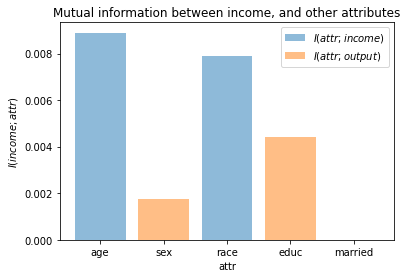

In [12]:

#NOTE that we should not use this but our own binding in the future
from sklearn.feature_selection import mutual_info_regression


trace_length=15000
attrs=['age','sex','race','educ','married']

y=[mutual_info_regression(np.concatenate(trace.posterior[attr],axis=0)[:trace_length,0].reshape(-1,1),
                          np.concatenate(trace.posterior['income'],axis=0)[:trace_length,0])[0] 
   for attr in ['age','sex','race','educ','married'] ]
# additionally we show the mutual information between the income of the first individual in the dataset and the different attributes
y1=[mutual_info_regression(np.concatenate(trace.posterior[attr],axis=0)[:trace_length,0].reshape(-1,1),
                          np.concatenate(trace.posterior['output'],axis=0)[:trace_length])[0]
   for attr in ['age','sex','race','educ','married'] ]


plt.bar(attrs,y, alpha=0.5,label="$I(attr;income)$")
plt.bar(attrs,y1,alpha=0.5,label="$I(attr;output)$")
plt.xlabel('attr')
plt.ylabel('$I(income;attr)$')
plt.title("Mutual information between income, and other attributes")
plt.legend(loc="best")
plt.show()